# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import seaborn as sns
from scipy.stats import norm
from scipy.stats import ranksums, wilcoxon

In [3]:
from backend import data_paths
from backend import evaluation_utils
from backend import gauge_groups_utils
from backend import metrics_utils

# Load Return Period Metrics

In [4]:
_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_1980_RETURN_PERIOD_METRICS_DIR,
}

In [5]:
precisions_by_lead_time = {}
recalls_by_lead_time = {}

precisions_by_return_period = {}
recalls_by_return_period = {}

for dataset, data_path in _DATASET_RETURN_PERIOD_METRICS_PATH.items():
    print(f'Working on {dataset} ...')
    file_path = data_paths.CONCATENATED_RETURN_PERIOD_DICTS_DIR / f'{dataset}_return_period_dicts.pkl'
    with open(file_path, 'rb') as f:
        precisions_by_lead_time[dataset], recalls_by_lead_time[dataset] = pkl.load(f)
    print(f'Finished loading {dataset}. \n')

Working on google_2014 ...
Finished loading google_2014. 

Working on google_1980 ...
Finished loading google_1980. 

Working on glofas_2014 ...
Finished loading glofas_2014. 

Working on glofas_1980 ...
Finished loading glofas_1980. 



# Calculate F1 Scores from Precision & Recall

In [6]:
f1s_by_lead_time = {
    dataset: {
        experiment: {
            lead_time:
              evaluation_utils.f1_from_precision_and_recall_dfs(
                  precision_df=precisions_by_lead_time[dataset][experiment][lead_time],
                  recall_df=recalls_by_lead_time[dataset][experiment][lead_time]
              ) for lead_time in data_paths.LEAD_TIMES
        } for experiment in precisions_by_lead_time[dataset]
    } for dataset in _DATASET_RETURN_PERIOD_METRICS_PATH
}

# Gauge Groups

In [7]:
gauges = gauge_groups_utils.get_full_gauge_group()
print(f'There are {len(gauges)} gauges.')

There are 5678 gauges.


In [8]:
ungauged_gauge_groups = gauge_groups_utils.load_all_ungauged_gauge_groups()

Working on kfold_splits ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3547.28it/s]


Working on continent_splits ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1718.86it/s]


Working on climate_splits ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 3348.64it/s]


Working on hydrologically_separated ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2392.81it/s]


# F1 Distributions over Continents

In [9]:
# Assign continents to each gauge.
continent_names = {split: split.replace('_', ' ').title() for split in ungauged_gauge_groups['continent_splits']}
gauge_continent_df = pd.Series(index=gauges, dtype=str, name='Continent')
for gauge in gauges:
    continent = [continent for continent, split_gauges in ungauged_gauge_groups['continent_splits'].items() if gauge in split_gauges][0]
    gauge_continent_df.loc[gauge] = continent_names[continent]

/tmp/ipykernel_1331668/1036728092.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(
/tmp/ipykernel_1331668/1036728092.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(
/tmp/ipykernel_1331668/1036728092.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(
/tmp/ipykernel_1331668/1036728092.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


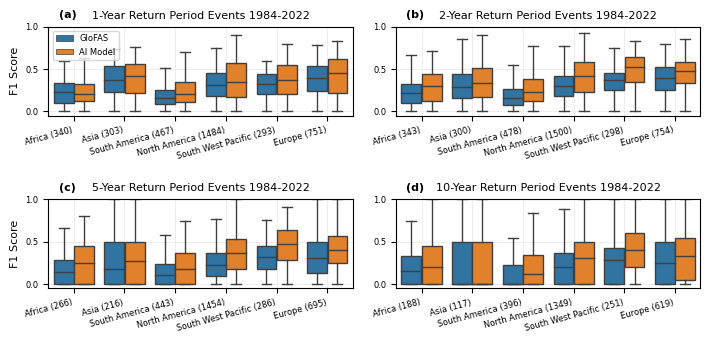

In [18]:
lead_time = 0
return_periods = evaluation_utils.RETURN_PERIODS[:-2]
experiments = [metrics_utils.GLOFAS_VARIABLE, 'kfold_splits']
experiment_names = {experiment: evaluation_utils.EXPERIMENT_NAMES[experiment] for experiment in experiments}
split_names = {split: split.replace('_', ' ').title() for split in ungauged_gauge_groups['continent_splits']}

metric = 'F1 Score'

fig, axes = plt.subplots(
    2, 2, 
    figsize=(
        evaluation_utils.NATURE_FIG_SIZES['two_column'], 
        evaluation_utils.NATURE_FIG_SIZES['two_column']/2
    )
)

panel_labels = ['(a)', '(b)', '(c)', '(d)']

for ridx, (ax, return_period, panel_label) in enumerate(zip(
    axes.flatten(), return_periods, panel_labels)):

    if metric.lower() == 'precision':
        plotdata = pd.concat(
            [
                gauge_continent_df,
                precisions_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
                    lead_time][return_period].rename(evaluation_utils.EXPERIMENT_NAMES[metrics_utils.GLOFAS_VARIABLE]),
                precisions_by_lead_time['google_1980']['kfold_splits'][
                    lead_time][return_period].rename(evaluation_utils.EXPERIMENT_NAMES['kfold_splits'])
            ], axis=1
        ).dropna()
    elif metric.lower() == 'recall':
        plotdata = pd.concat(
            [
                gauge_continent_df,
                recalls_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
                    lead_time][return_period].rename(evaluation_utils.EXPERIMENT_NAMES[metrics_utils.GLOFAS_VARIABLE]),
                recalls_by_lead_time['google_1980']['kfold_splits'][
                    lead_time][return_period].rename(evaluation_utils.EXPERIMENT_NAMES['kfold_splits'])
            ], axis=1
        ).dropna()
    elif metric.lower() == 'f1 score':
        plotdata = pd.concat(
            [
                gauge_continent_df,
                f1s_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
                    lead_time][return_period].rename(evaluation_utils.EXPERIMENT_NAMES[metrics_utils.GLOFAS_VARIABLE]),
                f1s_by_lead_time['google_1980']['kfold_splits'][
                    lead_time][return_period].rename(evaluation_utils.EXPERIMENT_NAMES['kfold_splits'])
            ], axis=1
        ).dropna()
    else:
        raise ValueError('Unknown metric')

    # Add sample size to all continent names.    
    continent_mapper = {}
    for continent in set(plotdata['Continent'].values):
        gauges_in_continent = plotdata.loc[plotdata['Continent'] == continent].index
        plotdata.loc[gauges_in_continent, 'continent_with_sample_size'] = f'{continent} ({len(gauges_in_continent)})'
    
    plotdata.rename(columns=experiment_names, inplace=True)
    dd = pd.melt(
        plotdata,
        id_vars=['continent_with_sample_size'],
        value_vars=experiment_names.values(),
        var_name='Model',
        value_name=metric
    )
    sns.boxplot(
        data=dd,
        x='continent_with_sample_size',
        y=metric,
        hue='Model',
        ax=ax,
        showfliers=False,
        linewidth=1
    )
    ax.set_ylim(-0.05, 1.0)
    ax.set_xlabel(None)
    ax.set_xticklabels(
        ax.get_xticklabels(), 
        rotation=15, 
        fontsize=evaluation_utils.NATURE_FONT_SIZES['tick_labels'],
        ha='right'
    )
    ax.set_yticklabels(
        ax.get_yticklabels(), 
        fontsize=evaluation_utils.NATURE_FONT_SIZES['tick_labels'],
    )
    ax.set_title(
        f'{int(return_period)}-Year Return Period Events 1984-2022', 
        fontsize=evaluation_utils.NATURE_FONT_SIZES['title']
    )
    ax.grid(c='#EEE')
    ax.set_axisbelow(True)
    
    if ax in axes[:, 0]:
        ax.set_ylabel(
            'F1 Score', 
            fontsize=evaluation_utils.NATURE_FONT_SIZES['axis_label'],
        )
    else:
        ax.set_ylabel(None)
    
    if ax != axes.flatten()[0]:
        ax.get_legend().remove()
    else:
        ax.legend(
            fontsize=evaluation_utils.NATURE_FONT_SIZES['legend'],
            loc='upper left'
        )

    ax.text(
        -0.3, 1.2,
        panel_label,
        fontsize=evaluation_utils.NATURE_FONT_SIZES['axis_label'],
        va='top',
        fontweight="bold"
    )

plt.tight_layout()

evaluation_utils.save_figure(data_paths.CONTINENT_RELIABILITY_SCORES_DISTRIBUTIONS_FILENAME)

# GloFAS Difference Between Continents

## Precisions -- GloFAS

In [11]:
for return_period in evaluation_utils.RETURN_PERIODS:
    df = pd.concat(
        [
            gauge_continent_df,
            precisions_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
                lead_time][return_period].rename(metrics_utils.GLOFAS_VARIABLE),
        ], axis=1
    ).dropna()

    continent_means = df.groupby(['Continent'])[metrics_utils.GLOFAS_VARIABLE].mean()
    
    print(f'--- {return_period = }-----------------------------------------------')
    print(continent_means)
    
    frac_diff = (continent_means.max() - continent_means.min()) / continent_means.max()
    print(frac_diff)

--- return_period = 1.01-----------------------------------------------
Continent
Africa                0.266145
Asia                  0.445563
Europe                0.408796
North America         0.349793
South America         0.243575
South West Pacific    0.347726
Name: glofas_prediction, dtype: float64
0.4533322960281054
--- return_period = 2-----------------------------------------------
Continent
Africa                0.266393
Asia                  0.353120
Europe                0.413845
North America         0.321386
South America         0.205122
South West Pacific    0.346001
Name: glofas_prediction, dtype: float64
0.5043502778394287
--- return_period = 5-----------------------------------------------
Continent
Africa                0.175126
Asia                  0.260630
Europe                0.340994
North America         0.253674
South America         0.157522
South West Pacific    0.303935
Name: glofas_prediction, dtype: float64
0.5380501670553528
--- return_period = 10---

## Recalls -- GloFAS

In [12]:
for return_period in evaluation_utils.RETURN_PERIODS:
    df = pd.concat(
        [
            gauge_continent_df,
            recalls_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
                lead_time][return_period].rename(metrics_utils.GLOFAS_VARIABLE),
        ], axis=1
    ).dropna()

    continent_means = df.groupby(['Continent'])[metrics_utils.GLOFAS_VARIABLE].mean()
    
    print(f'--- {return_period = }-----------------------------------------------')
    print(continent_means)
    
    frac_diff = (continent_means.max() - continent_means.min()) / continent_means.max()
    print(frac_diff)

--- return_period = 1.01-----------------------------------------------
Continent
Africa                0.207380
Asia                  0.347690
Europe                0.392804
North America         0.305710
South America         0.169673
South West Pacific    0.321218
Name: glofas_prediction, dtype: float64
0.5680476803469697
--- return_period = 2-----------------------------------------------
Continent
Africa                0.219794
Asia                  0.303178
Europe                0.381053
North America         0.305025
South America         0.186928
South West Pacific    0.382396
Name: glofas_prediction, dtype: float64
0.5111661323097466
--- return_period = 5-----------------------------------------------
Continent
Africa                0.172344
Asia                  0.218744
Europe                0.312225
North America         0.260746
South America         0.149646
South West Pacific    0.328610
Name: glofas_prediction, dtype: float64
0.5446076628734473
--- return_period = 10---

## F1s -- GloFAS

In [13]:
for return_period in evaluation_utils.RETURN_PERIODS:
    df = pd.concat(
        [
            gauge_continent_df,
            f1s_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][lead_time][
                return_period].rename(metrics_utils.GLOFAS_VARIABLE),
        ], axis=1
    ).dropna()

    continent_means = df.groupby(['Continent'])[metrics_utils.GLOFAS_VARIABLE].mean()
    
    print(f'--- {return_period = }-----------------------------------------------')
    print(continent_means)
    
    frac_diff = (continent_means.max() - continent_means.min()) / continent_means.max()
    print(frac_diff)

--- return_period = 1.01-----------------------------------------------
Continent
Africa                0.223651
Asia                  0.367861
Europe                0.384880
North America         0.314270
South America         0.184759
South West Pacific    0.317280
Name: glofas_prediction, dtype: float64
0.5199554540198402
--- return_period = 2-----------------------------------------------
Continent
Africa                0.224202
Asia                  0.306398
Europe                0.384619
North America         0.305090
South America         0.187560
South West Pacific    0.349901
Name: glofas_prediction, dtype: float64
0.5123473192535595
--- return_period = 5-----------------------------------------------
Continent
Africa                0.169748
Asia                  0.241195
Europe                0.319904
North America         0.246691
South America         0.147253
South West Pacific    0.302418
Name: glofas_prediction, dtype: float64
0.5396960832531055
--- return_period = 10---

# F1s -- Google

In [14]:
for return_period in evaluation_utils.RETURN_PERIODS:
    df = pd.concat(
        [
            gauge_continent_df,
            f1s_by_lead_time['google_1980']['kfold_splits'][
                lead_time][return_period].rename(evaluation_utils.EXPERIMENT_NAMES['kfold_splits'])
        ], axis=1
    ).dropna()

    continent_means = df.groupby(['Continent'])[evaluation_utils.EXPERIMENT_NAMES['kfold_splits']].mean()
    
    print(f'--- {return_period = }-----------------------------------------------')
    print(continent_means)
    
    frac_diff = (continent_means.max() - continent_means.min()) / continent_means.max()
    print(frac_diff, continent_means.max(), continent_means.min())

--- return_period = 1.01-----------------------------------------------
Continent
Africa                0.238792
Asia                  0.386659
Europe                0.451811
North America         0.371169
South America         0.240308
South West Pacific    0.397027
Name: AI Model, dtype: float64
0.47147793494230344 0.45181145950661866 0.23879232559516994
--- return_period = 2-----------------------------------------------
Continent
Africa                0.292098
Asia                  0.337328
Europe                0.446643
North America         0.406918
South America         0.264263
South West Pacific    0.511161
Name: AI Model, dtype: float64
0.483014075610495 0.511160716984942 0.2642628957820624
--- return_period = 5-----------------------------------------------
Continent
Africa                0.262328
Asia                  0.275652
Europe                0.385691
North America         0.357473
South America         0.210967
South West Pacific    0.456442
Name: AI Model, dtype: fl

# Statistical Tests with GloFAS Europe

In [15]:
lead_time = 0
return_periods = evaluation_utils.RETURN_PERIODS[:-2]
experiments = [metrics_utils.GLOFAS_VARIABLE, 'kfold_splits']
experiment_names = {experiment: evaluation_utils.EXPERIMENT_NAMES[experiment] for experiment in experiments}
split_names = {split: split.replace('_', ' ').title() for split in ungauged_gauge_groups['continent_splits']}

for metric in ['f1 score']: #['precision', 'recall', 'f1 score']:
    for ridx, (ax, return_period) in enumerate(zip(axes.flatten(), return_periods)):

        if metric.lower() == 'precision':
            plotdata = pd.concat(
                [
                    gauge_continent_df,
                    precisions_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
                        lead_time][return_period].rename(metrics_utils.GLOFAS_VARIABLE),
                    precisions_by_lead_time['google_1980']['kfold_splits'][
                        lead_time][return_period].rename('kfold_splits')
                ], axis=1
            ).dropna()
        elif metric.lower() == 'recall':
            plotdata = pd.concat(
                [
                    gauge_continent_df,
                    recalls_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
                        lead_time][return_period].rename(metrics_utils.GLOFAS_VARIABLE),
                    recalls_by_lead_time['google_1980']['kfold_splits'][
                        lead_time][return_period].rename('kfold_splits')
                ], axis=1
            ).dropna()
        elif metric.lower() == 'f1 score':
            plotdata = pd.concat(
                [
                    gauge_continent_df,
                    f1s_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
                        lead_time][return_period].rename(metrics_utils.GLOFAS_VARIABLE),
                    f1s_by_lead_time['google_1980']['kfold_splits'][
                        lead_time][return_period].rename('kfold_splits')
                ], axis=1
            ).dropna()
        else:
            raise ValueError('Unknown metric')

        plotdata.rename(columns=experiment_names, inplace=True)
        dd = pd.melt(
            plotdata, 
            id_vars=['Continent'], 
            value_vars=experiment_names.values(), 
            var_name='Model', 
            value_name=metric
        )

        # Statistical tests over continents.
        europe_glofas_df = dd.loc[(dd['Continent'] == 'Europe') & (
            dd['Model'] == evaluation_utils.EXPERIMENT_NAMES[metrics_utils.GLOFAS_VARIABLE])]
        for continent in set(dd['Continent']):
            continent_google_df = dd.loc[(dd['Continent'] == continent) & (
                dd['Model'] == evaluation_utils.EXPERIMENT_NAMES['kfold_splits'])]
            stats = ranksums(europe_glofas_df[metric], continent_google_df[metric])
            d = evaluation_utils.cohen_d(continent_google_df[metric].values, europe_glofas_df[metric].values)

            if d < 0 and stats.pvalue < 1e-2:
#             if continent == 'Africa':
                print(f'--- Test Against GloFAS Europe: {metric =} --- {continent =} --- {return_period =} ----')
                print(stats, d)
                frac_diff = (europe_glofas_df[metric].mean() - continent_google_df[metric].mean()) / europe_glofas_df[metric].mean()
                print(frac_diff)
                print('-------------------------------------------------------------------------------\n')

--- Test Against GloFAS Europe: metric ='f1 score' --- continent ='South America' --- return_period =1.01 ----
RanksumsResult(statistic=12.725764514658229, pvalue=4.252915789322636e-37) -0.7888755121336376
0.36864375821368156
-------------------------------------------------------------------------------

--- Test Against GloFAS Europe: metric ='f1 score' --- continent ='Africa' --- return_period =1.01 ----
RanksumsResult(statistic=12.853481353824257, pvalue=8.22248246776427e-38) -0.906562703909127
0.40800312814316064
-------------------------------------------------------------------------------

--- Test Against GloFAS Europe: metric ='f1 score' --- continent ='Asia' --- return_period =2 ----
RanksumsResult(statistic=3.2428841557988797, pvalue=0.001183263114857987) -0.2191790017310194
0.11329270448552753
-------------------------------------------------------------------------------

--- Test Against GloFAS Europe: metric ='f1 score' --- continent ='South America' --- return_period =

# Continent-by-Continent Statistical Tests

In [16]:
lead_time = 0
return_periods = evaluation_utils.RETURN_PERIODS[:-2]
experiments = [metrics_utils.GLOFAS_VARIABLE, 'kfold_splits']
experiment_names = {experiment: evaluation_utils.EXPERIMENT_NAMES[experiment] for experiment in experiments}
split_names = {split: split.replace('_', ' ').title() for split in ungauged_gauge_groups['continent_splits']}

for metric in ['f1 score']: #['precision', 'recall', 'f1 score']:
    for ridx, (ax, return_period) in enumerate(zip(axes.flatten(), return_periods)):

        if metric.lower() == 'precision':
            plotdata = pd.concat(
                [
                    gauge_continent_df,
                    precisions_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
                        lead_time][return_period].rename(metrics_utils.GLOFAS_VARIABLE),
                    precisions_by_lead_time['google_1980']['kfold_splits'][
                        lead_time][return_period].rename('kfold_splits')
                ], axis=1
            ).dropna()
        elif metric.lower() == 'recall':
            plotdata = pd.concat(
                [
                    gauge_continent_df,
                    recalls_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
                        lead_time][return_period].rename(metrics_utils.GLOFAS_VARIABLE),
                    recalls_by_lead_time['google_1980']['kfold_splits'][
                        lead_time][return_period].rename('kfold_splits')
                ], axis=1
            ).dropna()
        elif metric.lower() == 'f1 score':
            plotdata = pd.concat(
                [
                    gauge_continent_df,
                    f1s_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
                        lead_time][return_period].rename(metrics_utils.GLOFAS_VARIABLE),
                    f1s_by_lead_time['google_1980']['kfold_splits'][
                        lead_time][return_period].rename('kfold_splits')
                ], axis=1
            ).dropna()
        else:
            raise ValueError('Unknown metric')

        plotdata.rename(columns=experiment_names, inplace=True)
        dd = pd.melt(
            plotdata, 
            id_vars=['Continent'], 
            value_vars=experiment_names.values(), 
            var_name='Model', 
            value_name=metric
        )

        # Statistical tests over continents.
        for continent in set(dd['Continent']):
            google_df = dd.loc[(dd['Continent'] == continent) & (
                dd['Model'] == evaluation_utils.EXPERIMENT_NAMES['kfold_splits'])]
            glofas_df = dd.loc[(dd['Continent'] == continent) & (
                dd['Model'] == evaluation_utils.EXPERIMENT_NAMES[metrics_utils.GLOFAS_VARIABLE])]
            mean_difference = google_df[metric].mean() - glofas_df[metric].mean()
            stats = wilcoxon(google_df[metric], glofas_df[metric])
            d = evaluation_utils.cohen_d(google_df[metric].values, glofas_df[metric].values)
            
#             if mean_difference < 0 or stats.pvalue > 1e-2:
            if mean_difference < 0 or stats.pvalue > 1e-2: #print('!!!!!!!!!!!!')
                print(f'--- Continent-to-Continent Test: {metric=} --- {continent=} --- {return_period=} ----')
                print('Mean Difference:', mean_difference)
                print(stats, d)
                print('-------------------------------------------------------\n')

--- Continent-to-Continent Test: metric='f1 score' --- continent='Africa' --- return_period=1.01 ----
Mean Difference: 0.004196840511787481
WilcoxonResult(statistic=23411.5, pvalue=0.06960462965045766) 0.02812128519231496
-------------------------------------------------------

--- Continent-to-Continent Test: metric='f1 score' --- continent='Asia' --- return_period=5 ----
Mean Difference: 0.03531956641719203
WilcoxonResult(statistic=3908.0, pvalue=0.04415977939583954) 0.12158445920040643
-------------------------------------------------------

--- Continent-to-Continent Test: metric='f1 score' --- continent='Asia' --- return_period=10 ----
Mean Difference: 0.041446824780158126
WilcoxonResult(statistic=457.5, pvalue=0.17981598128594123) 0.11625831973888676
-------------------------------------------------------



In [17]:
lead_time = 0
return_periods = evaluation_utils.RETURN_PERIODS[:-2]
experiments = [metrics_utils.GLOFAS_VARIABLE, 'kfold_splits']
experiment_names = {experiment: evaluation_utils.EXPERIMENT_NAMES[experiment] for experiment in experiments}
split_names = {split: split.replace('_', ' ').title() for split in ungauged_gauge_groups['continent_splits']}

for metric in ['f1 score']: #['precision', 'recall', 'f1 score']:
    for ridx, (ax, return_period) in enumerate(zip(axes.flatten(), return_periods)):

        if metric.lower() == 'precision':
            plotdata = pd.concat(
                [
                    gauge_continent_df,
                    precisions_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
                        lead_time][return_period].rename(metrics_utils.GLOFAS_VARIABLE),
                    precisions_by_lead_time['google_1980']['kfold_splits'][
                        lead_time][return_period].rename('kfold_splits')
                ], axis=1
            ).dropna()
        elif metric.lower() == 'recall':
            plotdata = pd.concat(
                [
                    gauge_continent_df,
                    recalls_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
                        lead_time][return_period].rename(metrics_utils.GLOFAS_VARIABLE),
                    recalls_by_lead_time['google_1980']['kfold_splits'][
                        lead_time][return_period].rename('kfold_splits')
                ], axis=1
            ).dropna()
        elif metric.lower() == 'f1 score':
            plotdata = pd.concat(
                [
                    gauge_continent_df,
                    f1s_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
                        lead_time][return_period].rename(metrics_utils.GLOFAS_VARIABLE),
                    f1s_by_lead_time['google_1980']['kfold_splits'][
                        lead_time][return_period].rename('kfold_splits')
                ], axis=1
            ).dropna()
        else:
            raise ValueError('Unknown metric')

        plotdata.rename(columns=experiment_names, inplace=True)
        dd = pd.melt(
            plotdata, 
            id_vars=['Continent'], 
            value_vars=experiment_names.values(), 
            var_name='Model', 
            value_name=metric
        )

        # Statistical tests over continents.
        for continent in set(dd['Continent']):
            google_df = dd.loc[(dd['Continent'] == continent) & (
                dd['Model'] == evaluation_utils.EXPERIMENT_NAMES['kfold_splits'])]
            glofas_df = dd.loc[(dd['Continent'] == continent) & (
                dd['Model'] == evaluation_utils.EXPERIMENT_NAMES[metrics_utils.GLOFAS_VARIABLE])]
            mean_difference = google_df[metric].mean() - glofas_df[metric].mean()
            stats = wilcoxon(google_df[metric], glofas_df[metric])
            d = evaluation_utils.cohen_d(google_df[metric].values, glofas_df[metric].values)
            
#             if mean_difference < 0 or stats.pvalue > 1e-2:
            if mean_difference > 0 and stats.pvalue < 1e-2: #print('!!!!!!!!!!!!')
                print(f'--- Continent-to-Continent Test: {metric=} --- {continent=} --- {return_period=} ----')
                print('Mean Difference:', mean_difference)
                print(stats, d)
                print('-------------------------------------------------------\n')

--- Continent-to-Continent Test: metric='f1 score' --- continent='North America' --- return_period=1.01 ----
Mean Difference: 0.05734338407921796
WilcoxonResult(statistic=296649.0, pvalue=3.494904050544809e-50) 0.2801327874736311
-------------------------------------------------------

--- Continent-to-Continent Test: metric='f1 score' --- continent='Europe' --- return_period=1.01 ----
Mean Difference: 0.03695174511001287
WilcoxonResult(statistic=94317.0, pvalue=6.903780867787109e-15) 0.17883789097364763
-------------------------------------------------------

--- Continent-to-Continent Test: metric='f1 score' --- continent='Asia' --- return_period=1.01 ----
Mean Difference: 0.021476353271595805
WilcoxonResult(statistic=16699.0, pvalue=0.00024826465551645963) 0.10742494150583093
-------------------------------------------------------

--- Continent-to-Continent Test: metric='f1 score' --- continent='South America' --- return_period=1.01 ----
Mean Difference: 0.057965997368286004
Wilcox